In [16]:
import numpy as np, itertools
import tools21cm as t2c, numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from ipywidgets import interact

import astropy.units as u
import astropy.constants as cst
from astropy.cosmology import Planck18 as cosmo

## Mathematical Convolution
In mathematics, particularly in the context of signal processing and linear algebra, given two functions $ f(t) $ and $ g(t) $, the convolution of $ f $ and $ g $, denoted $ f \star g $, is defined by the integral:

$$ (f \star g)(\tau) = \int_{-\infty}^\infty{f(g)~g^*(t-\tau)~dt}= \int_{-\infty}^{\infty} f(t) \cdot g(\tau - t) \, dt $$

where $^*$ denotes the complex conjugate. For convolution, we omit the conjugate, using $g(\tau - t)$ in place of $g^*(t-\tau)$.

This integral represents the area under the curve of the product of $ f $ and $ g $, where $ g $ is flipped and shifted by $ \tau $ and then aligned with $ f $, with the integration performed over all possible values of $ t $. It allows for the analysis and manipulation of signals and systems by expressing the output of the convolution as a combination of the input signals.

In [26]:
# define two step function
def f(t):
    return np.where(np.abs(t) < 0.5, 1, 0)

def g(t):
    return np.where(np.abs(t) < 1, 1, 0)

ts = np.linspace(-5, 5, 1024)

def plot_convolution(offset):
    fig, axs = plt.subplots(figsize=(15,4), ncols=2, nrows=1)
    fig.subplots_adjust(hspace=0.5)
    
    axs[0].plot(ts, f(ts), 'b-', label='f')
    axs[0].plot(ts, g(ts - offset), 'r-', label='g')
    axs[0].fill_between(ts, f(ts) * g(ts - offset), 'k-', label='$f(t) g(t-\\tau)$')
    axs[1].plot(ts, np.convolve(f(ts), g(ts), mode='same'), 'k-', label='$f\\star g(\\tau)$')
    axs[1].plot([offset], np.sum(f(ts) * g(ts - offset)), 'kh', label='$\\int{f(t) g(t-\\tau) dt}$')
    
    axs[0].set_xlabel('Time [s]'), ax1.set_ylabel('Voltage')
    axs[1].set_xlabel('Delay [s]'), ax2.set_ylabel('Voltage Squared')
    for ax in axs: ax.legend(loc=1)
        
interact(plot_convolution, offset=(-4, 4, 0.1))

interactive(children=(FloatSlider(value=0.0, description='offset', max=4.0, min=-4.0), Output()), _dom_classes…

<function __main__.plot_convolution(offset)>

## The Convolution Theorem 
It is a fundamental result in signal processing that relates the convolution operation in the time (or spatial) domain to multiplication in the <b>Fourier transform</b> (or spatial frequency) domain. 

The Fourier transform (left) and the corresponding inverse (right) transform is defined as :
$$\tilde f(\omega) = \int_{-\infty}^\infty{f(t)\,e^{-i\omega t}\, dt}\,\,\,\,\,,\,\,\,\,\,\,\,f(t) = \frac{1}{2\pi}\int_{-\infty}^\infty{\tilde f(\omega)~e^{i\omega t}~d\omega}.
$$

The theorem states that the Fourier transform of the convolution of two functions is equal to the pointwise product of their Fourier transforms.

$$ \mathcal{F}[f \star g](\tau) = \tilde f (\omega) \cdot \tilde g(\omega) $$

where $ f(t) $ and $ g(t) $ are two function and $ \tilde f(\omega) $ and $ \tilde g(\omega) $ are their Fourier transforms, respectively. Here $ \mathcal{F} $ denote the Fourier operation.

In other words, <b>convolving two functions</b> in the <b>time domain</b> is equivalent to <b>multiplying their Fourier transforms</b> in the <b>frequency domain</b>. This theorem is particularly useful in observational radio astronomy as it provide the basis of the radio inteferometry telescope.

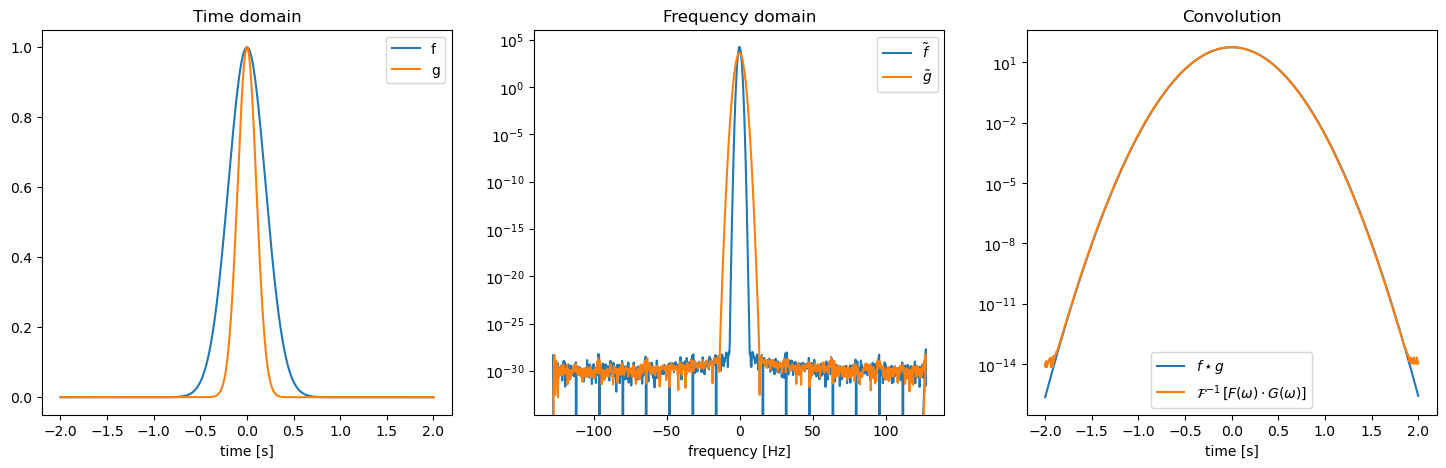

In [51]:
# define time domain
ts = np.linspace(-2, 2, 1024)

# fourier transform to get the frequncy domain
fqs = np.fft.fftfreq(ts.size, np.diff(ts)[0])

# define two functions f and g
def gaussian(t, sigma):
    return np.exp(-t**2 / (2*sigma**2))

f = gaussian(ts, 0.2)
g = gaussian(ts, 0.1)

# calculate convolution (time domain)
fg1 = np.convolve(f, g, mode='same')

# calculate fourier transform of f and g
fft_f = np.fft.fft(f)
fft_g = np.fft.fft(g)

# multiply the two fourier transform and inverse fourier transform
fg2 = np.fft.ifft(fft_f * fft_g)

fig, axs = plt.subplots(figsize=(18,5), ncols=3, nrows=1)
axs[0].set_title('Time domain')
axs[0].plot(ts, f, label='f')
axs[0].plot(ts, g, label='g')
axs[0].set_xlabel('time [s]')
axs[0].legend()

axs[1].set_title('Frequency domain')
axs[1].semilogy(fqs, np.abs(fft_f**2), label=r'$\tilde{f}$')
axs[1].semilogy(fqs, np.abs(fft_g**2), label=r'$\tilde{g}$')
axs[1].set_xlabel('frequency [Hz]')
axs[1].legend()

axs[2].set_title('Convolution')
axs[2].semilogy(ts, fg1, label=r'$f \star g$')
axs[2].semilogy(ts, np.fft.fftshift(fg2), label=r'$\mathcal{F}^{-1}\,[F(\omega) \cdot G(\omega)]$')
axs[2].set_xlabel('time [s]')
axs[2].legend()

__Remark :__ in python <i>np.fft</i> puts the zero-point of an array at the corners when compared to the <i>np.convolve</i>. We shift it over using <i>np.fft.fftshift</i>.

Also, <i>np.fft</i> library assumes finite arrays have periodic boundary conditions. As a result, the <i>np.fft</i> has small differences at the the edges of our time domain. This effect can be reduced by appling frequency filters (e.g. Blackman-Harrison window, etc..).